In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.mathtext').setLevel(logging.WARNING)

import sys, os
sys.path.append(os.path.abspath("metrics"))

from models.sbts_uni_markovian import *
from models.sbts_multi_markovian import *
from metrics.eval_functions import *
from metrics.get_params import *
from utils.data_generation import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Parameters Estimation: Illustration on Heston Data

In [32]:
M = 500
Generate_data = Generate_Data(M)

r_range = [0.02, 0.1]
kappa_range = [0.5, 4.]
theta_range = [0.5, 1.5]
rho_range = [-0.9, 0.9]
xi_range = [0.01, 0.9]
N = 252
deltati = 1/252

X_heston = Generate_data.generate_Heston(r_range, kappa_range, theta_range, rho_range, xi_range, N)
log_returns = np.zeros((M, N+1, 2))
log_returns[:,1:] = np.diff(np.log(X_heston), axis=1)
X_heston = X_heston[:, 1:]

print(X_heston.shape, log_returns.shape)

(500, 252, 2) (500, 253, 2)


In [48]:
log_returns_sbts = simulateSB_multi_mark(N, M, d=2, K=1, X=log_returns, N_pi=100, h=0.2, deltati=deltati, M_simu=500)
X_heston_sbts = np.exp(log_returns_sbts.cumsum(axis=1))

Start time: 08:06:22
Expected finish time: 08:10:55
Finish time: 08:10:52
Time with numba to generate 500 samples with N_pi=100: 269 seconds.


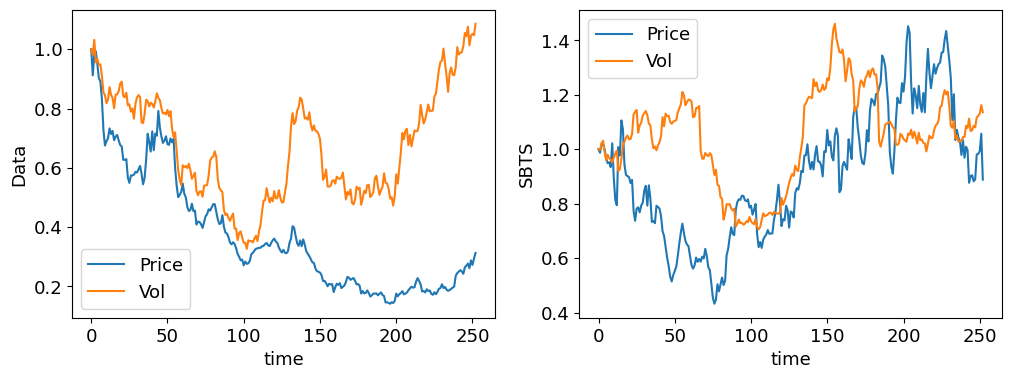

In [70]:
plot_sample_multi(X_heston, X_heston_sbts, ['Price', 'Vol'], 1)

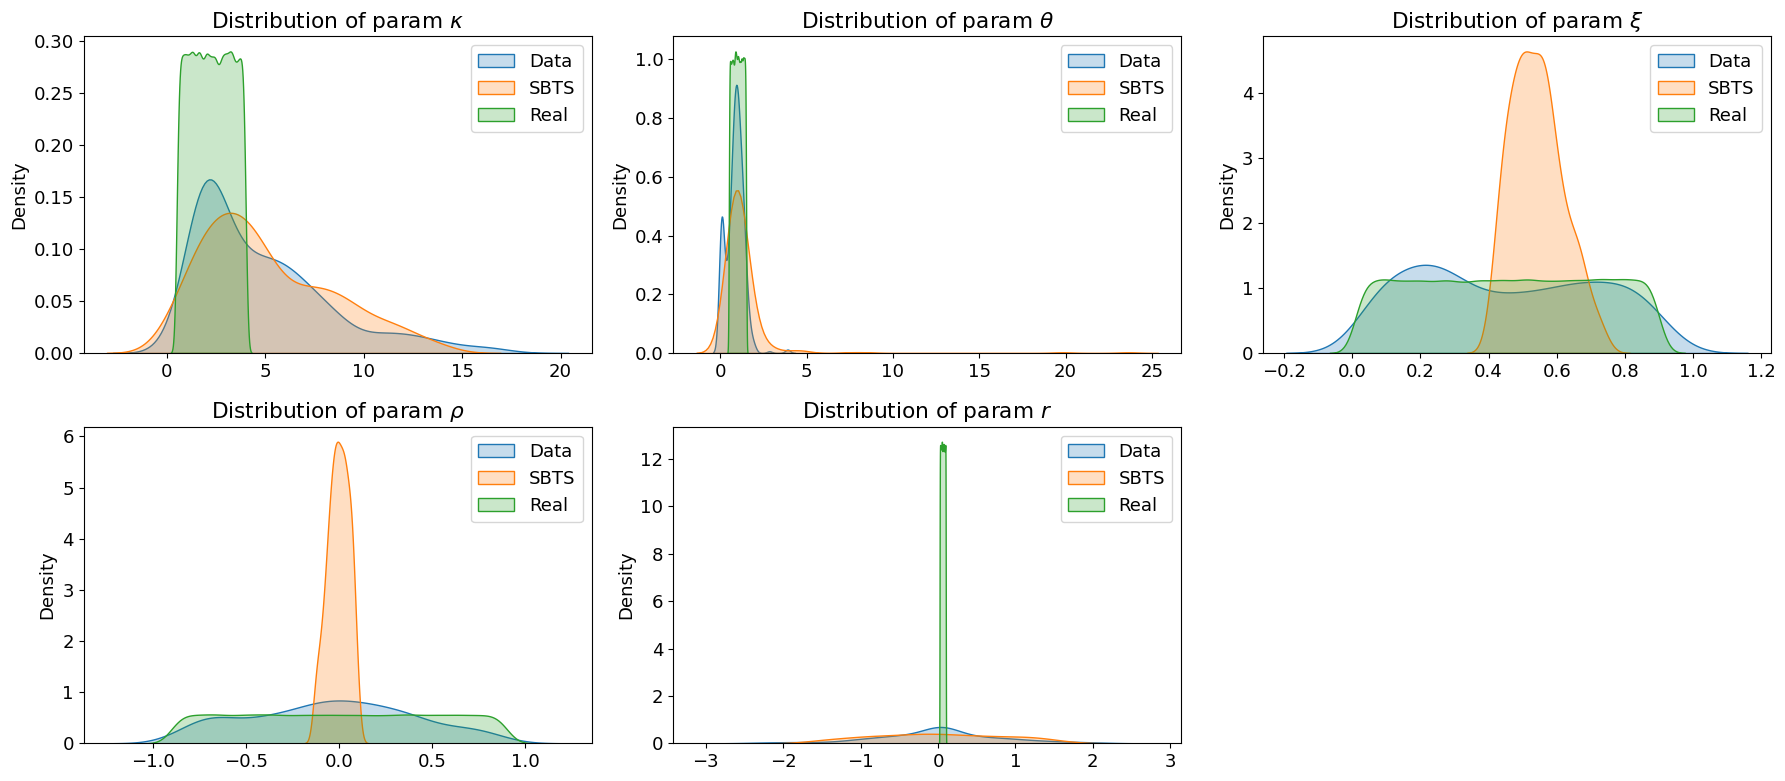

In [69]:
plot_params_distrib_Heston(X_heston, X_heston_sbts, dt=deltati)

## Discriminative and Predictive Score Computation: Illustration on Multivariate AR Data

In [4]:
M = 1000
Generate_AR_multi = Generate_Data(M)

N = 24
d=5
phi=0.5
sigma=0.8
x0=0
deltati = 1

X_ar = Generate_AR_multi.generate_AR_multi(N, d, phi, sigma, x0)

X_ar_sbts = simulateSB_multi_mark(N, M, d, K=1, X=X_ar, N_pi=100, h=0.5, deltati=deltati, M_simu=1000)
X_ar = X_ar[:, 1:]

Start time: 10:18:34
Expected finish time: 10:20:51
Finish time: 10:21:14
Time with numba to generate 1000 samples with N_pi=100: 159 seconds.


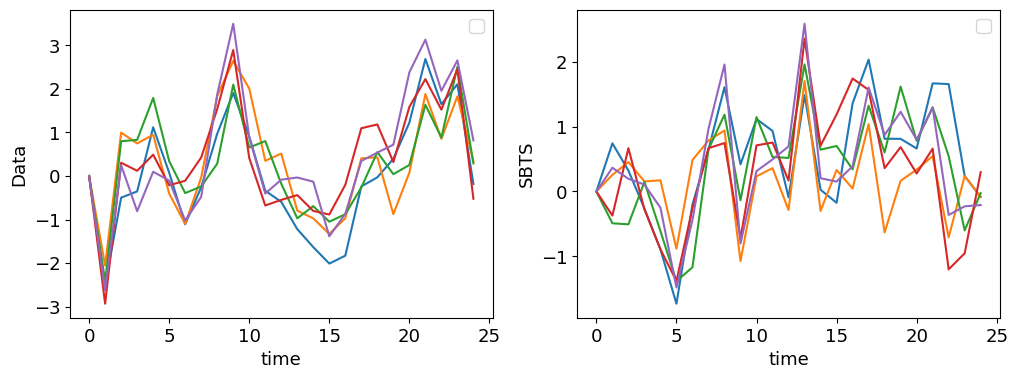

In [34]:
plot_sample_multi(X_ar, X_ar_sbts, x0=0)

In [5]:
disc, pred = get_scores(X_ar, X_ar_sbts, itt=2000, n_temp=10, min_max=True, device=device)

Start time: 10:21:14
Expected finish time: 11:02:21
Discriminative score (lower the better): 0.035 +- 0.022
Predictive score (lower the better): 0.09 +- 0.002
